In [ ]:
from shapely.geometry import Point, Polygon
import folium
import pytz
import pandas as pd
from datetime import time, timedelta
import datetime
import gpxpy
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import os

# IC Sessions 

In [ ]:
folder_path = '/home/kaptan/Desktop/CS210Data'

In [227]:



#Coordinates of IC
IC = [(40.889910,29.377778),(40.890542,29.377483),(40.890365,29.376584),(40.889653,29.376874)]
IC = Polygon(IC)

import pytz
from datetime import datetime

#Read he gpx file 
def parse_gpx(file_path):
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                
                utc_time = point.time.replace(tzinfo=pytz.utc)
                turkey_time = utc_time.astimezone(pytz.timezone('Europe/Istanbul'))

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'time': turkey_time,
                    'speed': point.speed
                })

    return data


#sort the gpx file by their entry time
def sort_by_time(data):
    return sorted(data, key=lambda x: x['time'])


#REturns pairs of entries and exits to the IC
def find_ic_entry_exit_times(gpx_data, time_gap_threshold=timedelta(minutes=5)):
    entries_and_exits = []
    last_point_time = None
    inside_ic = False

    for point in gpx_data:
        current_time = datetime.fromisoformat(point['time']) if isinstance(point['time'], str) else point['time']

        if last_point_time is not None:
            time_gap = current_time - last_point_time

            if time_gap > time_gap_threshold:
                if not inside_ic:
                    
                    entries_and_exits.append({'type': 'entry', 'time': last_point_time + time_gap_threshold})
                    inside_ic = True
                else:
                   
                    entries_and_exits.append({'type': 'exit', 'time': current_time})
                    inside_ic = False

        last_point_time = current_time

    
    if inside_ic:
        entries_and_exits.append({'type': 'exit', 'time': last_point_time})

    return entries_and_exits




#If a difference between an exit and a entry is too far apar make hem different sessions
def build_ic_sessions(entries_and_exits, session_gap=timedelta(hours=0.5)):
    ic_sessions = []
    current_session = None

    for i in range(0, len(entries_and_exits), 2):
        entry = entries_and_exits[i]['time']
        exit = entries_and_exits[i + 1]['time'] if i + 1 < len(entries_and_exits) else None

        if current_session is None:
            current_session = {'entry': entry, 'exit': exit, 'breaks': [], 'study_time': timedelta()}
        else:
            break_start = current_session['exit']
            break_duration = entry - break_start
            if break_duration > session_gap:
                current_session['study_time'] = current_session['exit'] - current_session['entry'] - sum((b[1] for b in current_session['breaks']), timedelta())
                ic_sessions.append(current_session)
                current_session = {'entry': entry, 'exit': exit, 'breaks': [], 'study_time': timedelta()}
            else:
                current_session['breaks'].append((break_start, break_duration))
                current_session['exit'] = exit

   
    if current_session is not None:
        current_session['study_time'] = current_session['exit'] - current_session['entry'] - sum((b[1] for b in current_session['breaks']), timedelta())
        ic_sessions.append(current_session)

    return ic_sessions






#process a single gpx file
def process_gpx_file(file_path):
    gpx_data = parse_gpx(file_path)
    gpx_data = sort_by_time(gpx_data)
    ic_entries_exits = find_ic_entry_exit_times(gpx_data)
    ic_sessions = build_ic_sessions(ic_entries_exits)
    all_breaks = []
    for session in ic_sessions:
        for brk in session['breaks']:
            all_breaks.append(brk)

    # Extracting date from the filename (assuming the format 'YYYY-MM-DD.gpx')
    date = os.path.basename(file_path).split('.')[0]
    date = gpx_data[0]['time'].date() if gpx_data else None
    # Calculating total time in IC and formatting session times
    total_time_in_ic = sum((session['study_time'] for session in ic_sessions), timedelta()).total_seconds() / 60
    total_time_in_ic = int(total_time_in_ic)
    merged_ic_visits = ', '.join([f"{session['entry'].strftime('%H:%M:%S')} - {session['exit'].strftime('%H:%M:%S')}" for session in ic_sessions])

    return {
        'Date': date,
        'merged_ic_visits': merged_ic_visits,
        'total_time_in_ic': total_time_in_ic,
        'entry_time': ic_sessions[0]['entry'].strftime('%H:%M:%S') if ic_sessions else None,
        'exit_time': ic_sessions[-1]['exit'].strftime('%H:%M:%S') if ic_sessions else None,
        'breaks': all_breaks
    }

#process all he gpx files in the folder

def process_all_gpx_files(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.gpx')]
    all_data = []

    for file in files:
        file_path = os.path.join(folder_path, file)
        file_data = process_gpx_file(file_path)
        all_data.append(file_data)

    return pd.DataFrame(all_data)


In [ ]:
df_IC = process_all_gpx_files(folder_path)

# Class Attandance And Leasure Time

In [224]:


istanbul_tz = pytz.timezone('Europe/Istanbul')

#All of my lectures
lectures = [
    ["CS 303", "Monday", time(8, 40), time(9, 30), "Fens"],
    ["Math 306R", "Monday", time(9, 40), time(10, 30), "Fens"],
    ["CIP 101", "Monday", time(12, 40), time(15, 30), "Fass"],
    ["CS 204", "Monday", time(16, 40), time(18, 30), "Fman"],
    ["CS 303L", "Tuesday", time(9, 40), time(11, 30), "Fens"],
    ["HUM 207", "Tuesday", time(14, 40), time(16, 30), "Fass"],
    ["CS 210R", "Tuesday", time(16, 40), time(18, 30), "Fens"],
    ["Math 306R", "Wednesday", time(8, 40), time(10, 30), "Fens"],
    ["CS 204", "Wednesday", time(12, 40), time(13, 30), "Fman"],
    ["CS 210", "Wednesday", time(16, 40), time(17, 30), "Fens"],
    ["CS 303", "Thursday", time(12, 40), time(14, 30), "Fens"],
    ["HUM 207D", "Thursday", time(15, 40), time(16, 30), "Fass"],
    ["CS 303R", "Thursday", time(17, 40), time(18, 30), "Fens"],
    ["MATH 306", "Friday", time(8, 40), time(9, 30), "Fens"],
    ["CS 204R", "Friday", time(10, 40), time(12, 30), "Fens"],
    ["CS 210", "Friday", time(12, 40), time(14, 30), "Fens"]
]

#parse a Single gpx file
def parse_gpx(file_path):
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                # Convert time to Turkey Time
                utc_time = point.time.replace(tzinfo=pytz.utc)
                turkey_time = utc_time.astimezone(pytz.timezone('Europe/Istanbul'))

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'time': turkey_time,
                    'speed': point.speed
                })

    return data

#sort the data
def sort_by_time(data):
    return sorted(data, key=lambda x: x['time'])





#Coordinates of the buildings
FENS = [(40.890832, 29.378656), (40.891034, 29.379525), (40.890361, 29.379863), (40.890120, 29.378889)]
FENS = Polygon(FENS)
FMAN = [(40.892482,29.379052),(40.891730,29.379339),(40.891514,29.378383),(40.892225,29.378338)]
FMAN = Polygon(FMAN)
FASS = [(40.890138,29.378724),(40.890778, 29.378417),(40.890603,29.377538),(40.889930,29.377845)]
FASS = Polygon(FASS)
CENTER =[(40.891973,29.380788),(40.892062,29.381618),(40.891,29.381821),(40.891130,29.381102)]
CENTER = Polygon(CENTER)

buildingsMap = {"Fens":FENS,"Fman":FMAN,"Fass":FASS,"Center":CENTER}




#If my entry and exit times are too close combine them together
def combine_sessions(entry_and_exits, gap_threshold=timedelta(minutes=5)):
    
    entry_and_exits.sort(key=lambda x: x[0])

    combined_sessions = []
    current_session = None

    for entry, exit in entry_and_exits:
        if not isinstance(entry, datetime):
            entry = datetime.fromisoformat(entry)
        if not isinstance(exit, datetime):
            exit = datetime.fromisoformat(exit)

        if current_session is None:
            current_session = [entry, exit]
        else:
           
            if entry - current_session[1] <= gap_threshold:
                
                current_session[1] = exit
            else:
                
                combined_sessions.append((current_session[0], current_session[1]))
                current_session = [entry, exit]


    if current_session is not None:
        combined_sessions.append((current_session[0], current_session[1]))

    return [(session[0].isoformat(), session[1].isoformat()) for session in combined_sessions]


#get entry and exit pairs from the building
def entry_exit_based_on_gaps(gpx_data, building_polygon):
    entry_and_exits = []
    inside_building = False
    entry_time = None
    last_inside_time = None

    for i in range(len(gpx_data)):
        current_point = Point(gpx_data[i]['latitude'], gpx_data[i]['longitude'])
        current_time = gpx_data[i]['time']

        if building_polygon.contains(current_point):
            if not inside_building:
                
                inside_building = True
                entry_time = current_time
            last_inside_time = current_time  
        else:
            if inside_building:
                
                inside_building = False
                if last_inside_time and (last_inside_time - entry_time) >= timedelta(minutes=5):
                    entry_and_exits.append((entry_time, last_inside_time))

                
                entry_time = None
                last_inside_time = None

   
    return combine_sessions(entry_and_exits)

#get all the attandances
def find_all_entry_exit_times(gpx_data, buildingsMap):
    all_building_times = {}
    for building_name, building_polygon in buildingsMap.items():
        building_times = entry_exit_based_on_gaps(gpx_data, building_polygon)
        all_building_times[building_name] = building_times

    return all_building_times



# Convert lectures list to a DataFrame
df_lectures = pd.DataFrame(lectures, columns=["Course", "Day", "Start", "End", "Building"])


data = pd.DataFrame()

for index, row in df_lectures.iterrows():
    column_name = row['Course'].replace(" ", "") + row['Day']  
    data[column_name] = None  



# get the aware datetime
def to_datetime_with_date(time_obj, date):
    naive_datetime = datetime.combine(date, time_obj)
    aware_datetime = istanbul_tz.localize(naive_datetime)
    return aware_datetime


# Rerturns overlap between 2 timeframes
def overlap_duration(start1, end1, start2, end2):
    if start1.date() != start2.date():
        return 0  

    latest_start = max(start1, start2)
    earliest_end = min(end1, end2)
    delta = (earliest_end - latest_start).total_seconds() / 60  
    return max(0, delta)

#Processes the gpx files and exracts which classes I did attend to during the day and the times that I have been to the univercity center
def process_gpx_file(file_path, lectures, buildingsMap):
    gpx_data = parse_gpx(file_path)
    gpx_data = sort_by_time(gpx_data)
    date = gpx_data[0]['time'].date() if gpx_data else None

    all_building_times = find_all_entry_exit_times(gpx_data, buildingsMap)

    row_data = {lecture['Course'].replace(" ", "") + lecture['Day']: 0 for lecture in lectures}
    row_data['Date'] = date

    cafe_food_times = []
    total_cafe_food = timedelta(0)

  
    for lecture in lectures:
        column_name = lecture['Course'].replace(" ", "") + lecture['Day']
        lecture_start = to_datetime_with_date(lecture['Start'], date)
        lecture_end = to_datetime_with_date(lecture['End'], date)


        if lecture_start.strftime('%A') != lecture['Day']:
            
            continue

        for building, times in all_building_times.items():
            if building == lecture['Building']:
                for entry_time, exit_time in times:
                    entry_time = datetime.fromisoformat(entry_time)
                    exit_time = datetime.fromisoformat(exit_time)

                    

                    overlap = overlap_duration(lecture_start, lecture_end, entry_time, exit_time)
                   

                    if overlap >= 30:
                        row_data[column_name] = 1
                        
                        break
        
    if 'Center' in buildingsMap:
        for entry_time, exit_time in all_building_times.get('Center', []):
            entry_time = datetime.fromisoformat(entry_time)
            exit_time = datetime.fromisoformat(exit_time)

            cafe_food_times.append(f"{entry_time.strftime('%H:%M:%S')} - {exit_time.strftime('%H:%M:%S')}")
            total_cafe_food += exit_time - entry_time

    
    total_cafe_food_minutes = total_cafe_food.total_seconds() / 60

    
    row_data['Cafe/Food_times'] = ', '.join(cafe_food_times)
    row_data['total_Cafe/Food'] = total_cafe_food_minutes

    return row_data

#read all of the files in the folder
def process_all_gpx_files_lecture(folder_path, lectures, buildingsMap):
    all_rows = []

    for file in os.listdir(folder_path):
        if file.endswith('.gpx'):
            file_path = os.path.join(folder_path, file)
            row_data = process_gpx_file(file_path, lectures, buildingsMap)
            all_rows.append(row_data)

    return pd.DataFrame(all_rows)




In [225]:

df_lectures = pd.DataFrame(lectures, columns=["Course", "Day", "Start", "End", "Building"])
df_lectureA = process_all_gpx_files_lecture(folder_path, df_lectures.to_dict('records'), buildingsMap)


In [229]:
df_lectureA['Date'] = pd.to_datetime(df_lectureA['Date'])
df_IC['Date'] = pd.to_datetime(df_IC['Date'])
df_IC['day_of_week'] = df_IC['Date'].dt.day_name()

In [230]:
df = pd.merge(df_IC, df_lectureA, on='Date', how='outer')
df = df.sort_values(by='Date')

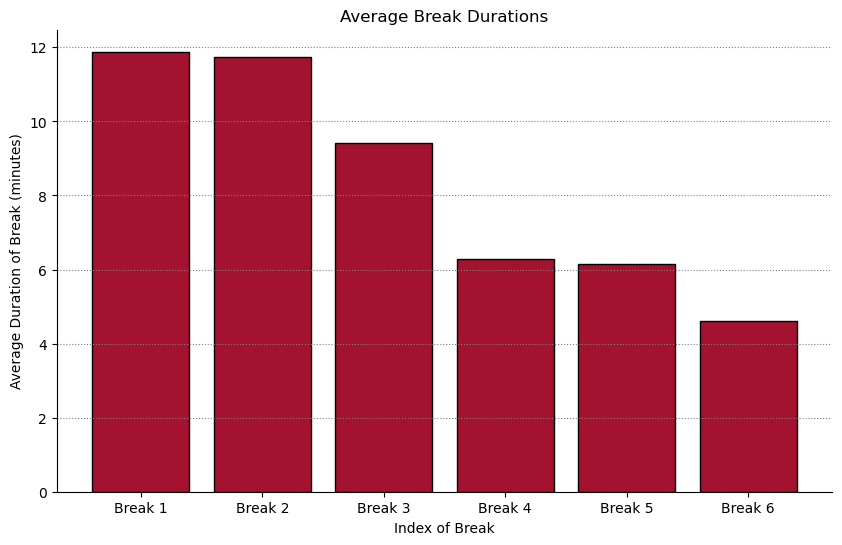

In [232]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Organize breaks by their index
breaks_by_index = defaultdict(list)
for _, row in df.iterrows():
    for index, brk in enumerate(row['breaks']):
        break_duration_minutes = brk[1].total_seconds() / 60  # Convert seconds to minutes
        breaks_by_index[index].append(break_duration_minutes)

# Calculate the average duration for each break index
average_break_durations = [sum(durations) / len(durations) for durations in breaks_by_index.values()]

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart for average break durations using the axes object
ax.bar(range(len(average_break_durations)), average_break_durations, color='#a3132f',ec = "black", zorder = 1)

# Set labels and title
ax.set_xlabel('Index of Break')
ax.set_ylabel('Average Duration of Break (minutes)')
ax.set_title('Average Break Durations')

# Set x-ticks
ax.set_xticks(range(len(average_break_durations)))
ax.set_xticklabels([f'Break {i+1}' for i in range(len(average_break_durations))])

# Apply grid and spine formatting
ax.grid(axis='y', color = "grey", ls = ":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()

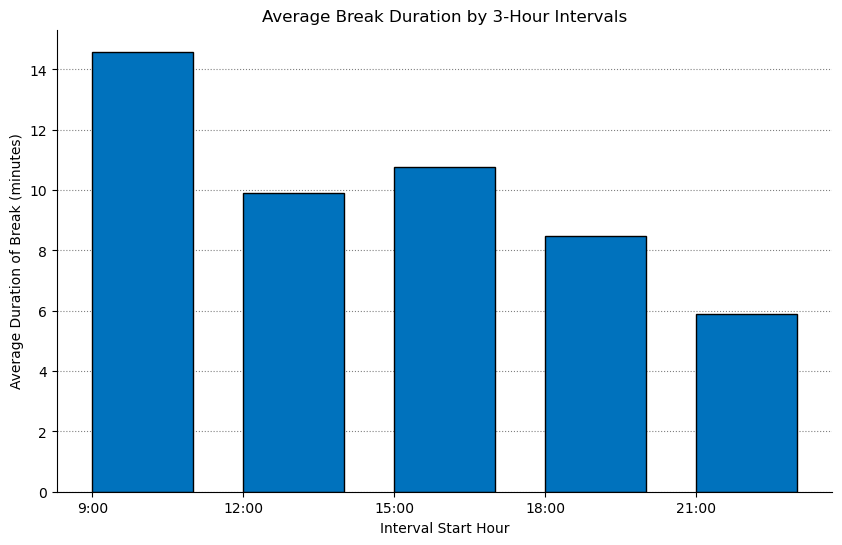

In [233]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to assign hour to a 2.5-hour interval
def assign_to_interval(hour):
    return int(np.floor(hour / 3) * 3)

# Extract breaks with interval and duration
breaks_by_interval = defaultdict(list)
for _, row in df.iterrows():
    for brk in row['breaks']:
        interval = assign_to_interval(brk[0].hour)  # Group by 2.5-hour interval
        break_duration_minutes = brk[1].total_seconds() / 60  # Convert duration to minutes
        breaks_by_interval[interval].append(break_duration_minutes)

# Calculate average duration for each interval
average_duration_by_interval = {interval: sum(durations) / len(durations) for interval, durations in breaks_by_interval.items()}

# Sort the intervals for plotting
sorted_intervals = sorted(average_duration_by_interval.keys())
average_durations = [average_duration_by_interval[interval] for interval in sorted_intervals]


# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart using the axes object
ax.bar(sorted_intervals, average_durations, color='#0072bd', width=2, align='edge', ec = "black", zorder = 2)

# Set labels and title using the axes object
ax.set_xlabel('Interval Start Hour')
ax.set_ylabel('Average Duration of Break (minutes)')
ax.set_title('Average Break Duration by 3-Hour Intervals')

# Set x-ticks using the axes object
ax.set_xticks(sorted_intervals)
ax.set_xticklabels([f'{interval}:00' for interval in sorted_intervals])

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color = "grey", ls = ":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()


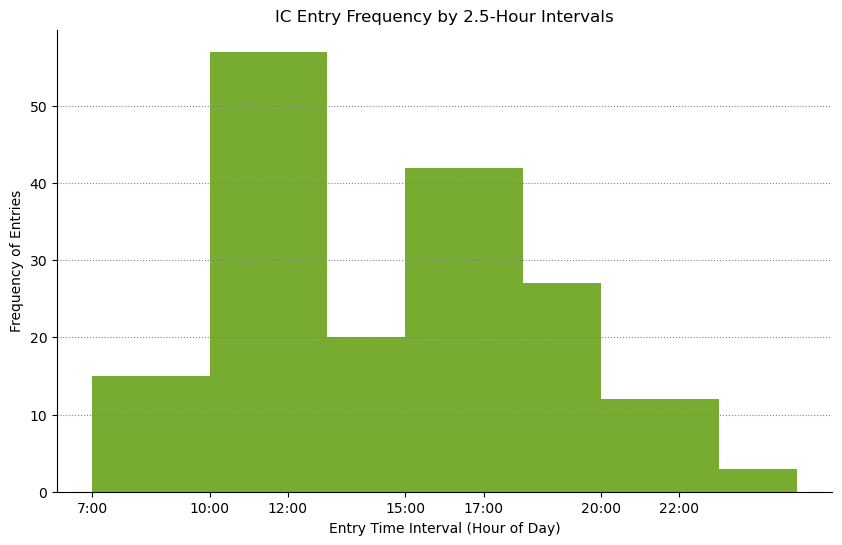

In [192]:
from collections import Counter
# Function to categorize a time into a 2.5-hour interval
def assign_to_interval(hour):
    return int(np.floor(hour / 2.5) * 2.5)

# Extract IC entry times and categorize them into intervals
entry_intervals = []
for file in os.listdir(folder_path):
    if file.endswith('.gpx'):
        file_path = os.path.join(folder_path, file)
        gpx_data = parse_gpx(file_path)
        gpx_data = sort_by_time(gpx_data)
        ic_entries_exits = find_ic_entry_exit_times(gpx_data)

        for entry_exit in ic_entries_exits:
            if entry_exit['type'] == 'entry':
                entry_hour = entry_exit['time'].hour
                interval = assign_to_interval(entry_hour)
                entry_intervals.append(interval)

# Count the frequency of entries in each interval
interval_counts = Counter(entry_intervals)

# Sort the intervals for plotting
sorted_intervals = sorted(interval_counts.keys())
frequencies = [interval_counts[interval] for interval in sorted_intervals]

# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart using the axes object
ax.bar(sorted_intervals, frequencies, color='#78ac30', width=3, align='edge',  zorder = 1)

# Set labels and title using the axes object
ax.set_xlabel('Entry Time Interval (Hour of Day)')
ax.set_ylabel('Frequency of Entries')
ax.set_title('IC Entry Frequency by 2.5-Hour Intervals')

# Set x-ticks using the axes object
ax.set_xticks(sorted_intervals)
ax.set_xticklabels([f'{interval}:00' for interval in sorted_intervals])

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color = "grey", ls = ":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()


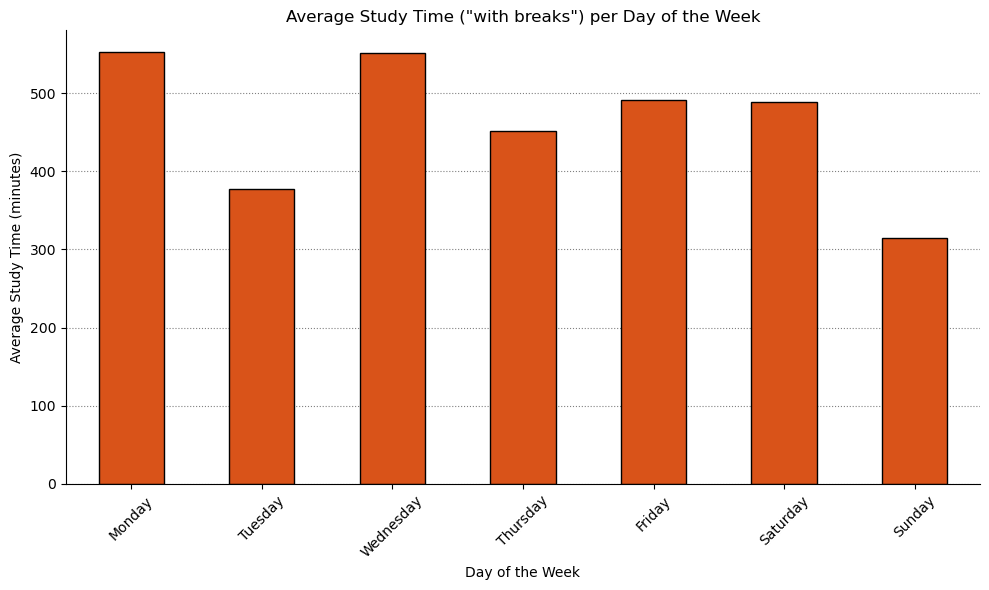

In [234]:
average_study_time_by_day = df.groupby('day_of_week')['total_time_in_ic'].mean()

# Reorder the days of the week for a better graph presentation
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_study_time_by_day = average_study_time_by_day.reindex(days_order)



# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar graph using the axes object
average_study_time_by_day.plot(kind='bar', color='#d95319', ax=ax, ec = "black", zorder = 2)

# Set title and labels using the axes object
ax.set_title('Average Study Time ("with breaks") per Day of the Week')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Study Time (minutes)')

# Customize x-ticks using the axes object
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color = "grey", ls = ":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()


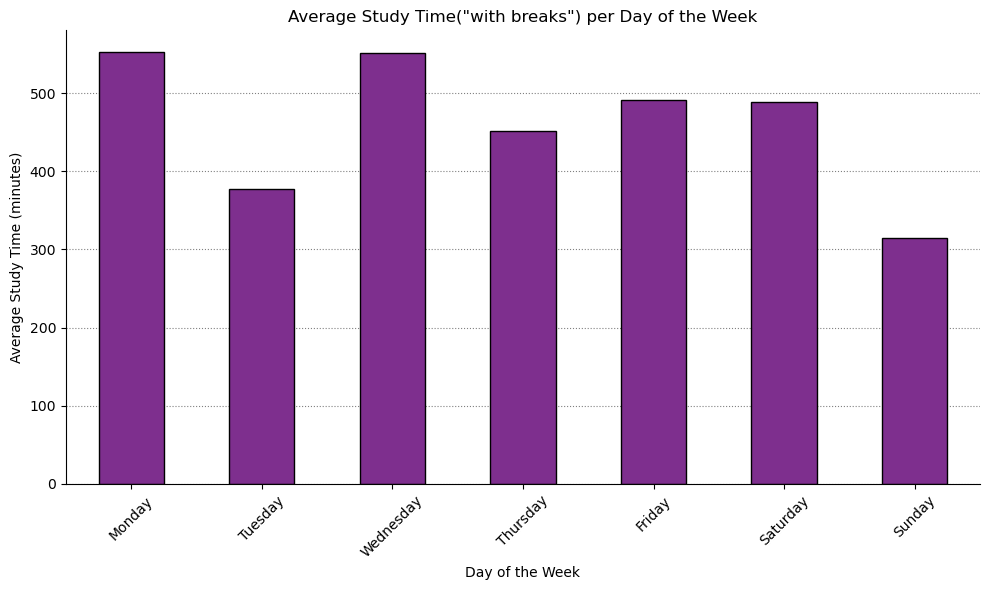

In [235]:
# Days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Initialize a dictionary to hold attendance data
attendance_data = {day: {'attended': 0, 'total': 0} for day in days}

# Iterate over each row to calculate attendance
for _, row in df.iterrows():
    day_of_week = row['Date'].strftime('%A')
    if day_of_week in days:
        # Columns for the current day
        day_columns = [col for col in big_df.columns if day_of_week in col]

        # Total and attended classes for this day
        total_classes = len(day_columns)
        attended_classes = sum([row[col] for col in day_columns if pd.notna(row[col])])

        # Update attendance data
        attendance_data[day_of_week]['total'] += total_classes
        attendance_data[day_of_week]['attended'] += attended_classes

# Calculate attendance percentages
attendance_percentages = {day: (data['attended'] / data['total'] * 100) if data['total'] > 0 else 0 
                          for day, data in attendance_data.items()}

'''
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(attendance_percentages.keys(), attendance_percentages.values())
plt.xlabel('Day of the Week')
plt.ylabel('Attendance Percentage')
plt.title('Attendance Percentage by Day of the Week')
plt.ylim(0, 100)
plt.show()
'''

# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar graph using the axes object
average_study_time_by_day.plot(kind='bar', color='#7e2f8e', ax=ax, ec = "black", zorder = 2)

# Set title and labels using the axes object
ax.set_title('Average Study Time("with breaks") per Day of the Week')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Study Time (minutes)')

# Customize x-ticks using the axes object
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color = "grey", ls = ":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_154837/2344010217.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_class_names, rotation=45)


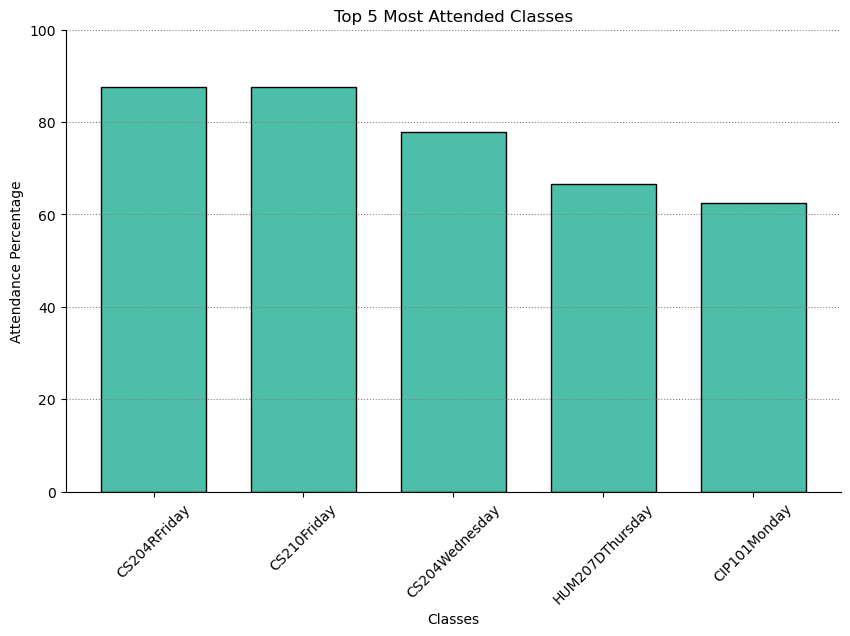

In [204]:
# Initialize a dictionary to hold attendance data for each class
class_attendance = {}

# Iterate over each row to calculate attendance for each class
for _, row in big_df.iterrows():
    day_of_week = row['Date'].strftime('%A')
    for col in big_df.columns:
        if col not in ['Date'] and day_of_week in col:
            if col not in class_attendance:
                class_attendance[col] = {'attended': 0, 'total': 0}
            
            class_attendance[col]['total'] += 1
            if pd.notna(row[col]) and row[col] == 1:
                class_attendance[col]['attended'] += 1

# Calculate attendance percentage for each class
for class_name, data in class_attendance.items():
    total = data['total']
    attended = data['attended']
    percentage = (attended / total * 100) if total > 0 else 0
    class_attendance[class_name]['percentage'] = percentage

# Sort classes by attendance percentage and select top 5
top_classes = sorted(class_attendance.items(), key=lambda x: x[1]['percentage'], reverse=True)[:5]

# Extracting class names and their percentages
top_class_names = [class_name for class_name, _ in top_classes]
top_class_percentages = [data['percentage'] for _, data in top_classes]


# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting using the axes object
ax.bar(top_class_names, top_class_percentages, color='#4dbfa8', ec = "black", zorder = 1, width=0.7)

# Set labels and title using the axes object
ax.set_xlabel('Classes')
ax.set_ylabel('Attendance Percentage')
ax.set_title('Top 5 Most Attended Classes')

# Set y-axis limits using the axes object
ax.set_ylim(0, 100)

# Customize x-ticks using the axes object
ax.set_xticklabels(top_class_names, rotation=45)

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color="grey", linestyle=":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()

/tmp/ipykernel_154837/734999107.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_class_names, rotation=45)


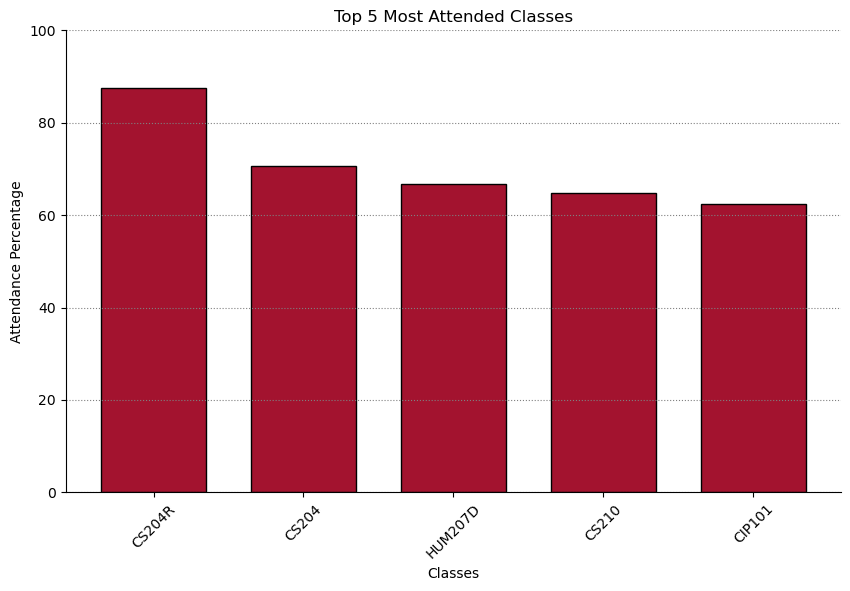

In [236]:
import pandas as pd
from matplotlib import pyplot as plt

# Assuming 'big_df' is the DataFrame containing all the data
# And assuming 'big_df' has a 'day_of_week' column with the correct day of the week for each date

# Initialize a dictionary to hold attendance data for each class
class_attendance = {}

# Iterate over each row to calculate attendance for each class
for _, row in big_df.iterrows():
    day_of_week = row['day_of_week']  # This should be the actual day of the week, e.g., 'Monday'
    
    # Only consider columns for the current day of the week
    relevant_classes = [col for col in big_df.columns if day_of_week in col]
    
    for col in relevant_classes:
        # Extract the class name without the day
        class_name = col.replace(day_of_week, '')
        if class_name not in class_attendance:
            class_attendance[class_name] = {'attended': 0, 'total': 0}
        
        class_attendance[class_name]['total'] += 1
        if pd.notna(row[col]) and row[col] == 1:
            class_attendance[class_name]['attended'] += 1

# Calculate attendance percentage for each class
for class_name, data in class_attendance.items():
    total = data['total']
    attended = data['attended']
    percentage = (attended / total * 100) if total > 0 else 0
    class_attendance[class_name]['percentage'] = percentage

# Sort classes by attendance percentage and select top 5
top_classes = sorted(class_attendance.items(), key=lambda x: x[1]['percentage'], reverse=True)[:5]

# Extracting class names and their percentages
top_class_names = [class_name for class_name, _ in top_classes]
top_class_percentages = [data['percentage'] for _, data in top_classes]


# Create the figure and axes objects for customizing the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting using the axes object
ax.bar(top_class_names, top_class_percentages, color='#a3132f', ec = "black", zorder = 1, width=0.7)

# Set labels and title using the axes object
ax.set_xlabel('Classes')
ax.set_ylabel('Attendance Percentage')
ax.set_title('Top 5 Most Attended Classes')

# Set y-axis limits using the axes object
ax.set_ylim(0, 100)

# Customize x-ticks using the axes object
ax.set_xticklabels(top_class_names, rotation=45)

# Apply grid and spine formatting using the axes object
ax.grid(axis='y', color="grey", linestyle=":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()


In [136]:
# Sum the total time spent at the university center
total_time_at_center = df['total_Cafe/Food'].sum()

# Count the number of days spent at the university center (days with non-zero time)
days_at_center = df[df['total_Cafe/Food'] > 0].shape[0]

# Calculate the average time spent per day at the university center
average_time_per_day = total_time_at_center / days_at_center if days_at_center > 0 else 0

print(f"Average time spent at the university center per day: {average_time_per_day} minutes")


Average time spent at the university center per day: 59.05072463768115 minutes


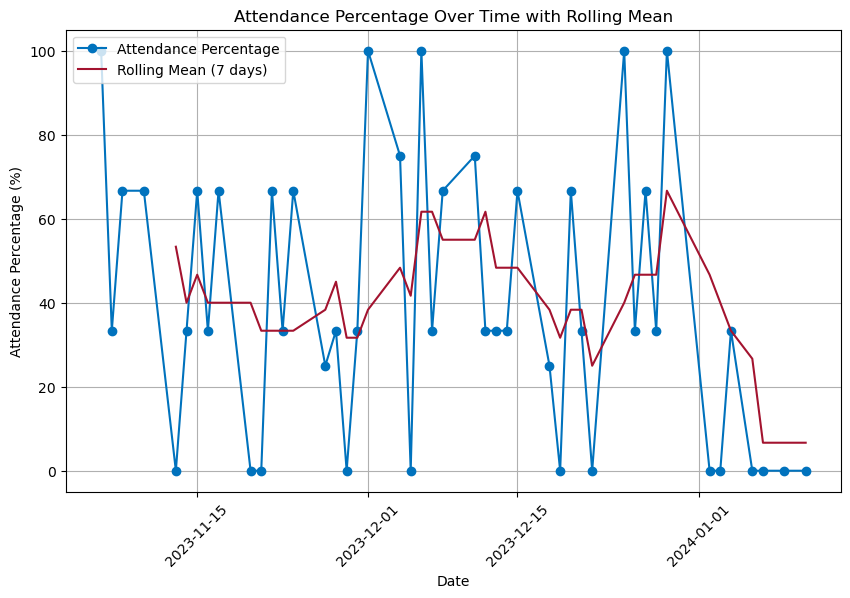

In [217]:
def calculate_daily_attendance_percentage(df):
    attendance_percentages = []

    for index, row in df.iterrows():
        day_of_week = row['Date'].strftime('%A')
        relevant_columns = [col for col in df.columns if day_of_week in col]
        total_classes = len(relevant_columns)
        attended_classes = row[relevant_columns].sum()
        attendance_percentage = (attended_classes / total_classes) * 100 if total_classes else 0
        attendance_percentages.append(attendance_percentage)

    return attendance_percentages


# Calculate attendance percentages
df['Attendance_Percentage'] = calculate_daily_attendance_percentage(df)

# Add a rolling mean with a window size of, for example, 7 days
df['Rolling_Mean'] = df['Attendance_Percentage'].rolling(window=5).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Attendance_Percentage'], color='#0072bd' ,marker='o', linestyle='-', label='Attendance Percentage')
plt.plot(df['Date'], df['Rolling_Mean'], color='#a3132f', linestyle='-', label='Rolling Mean (7 days)')
plt.title('Attendance Percentage Over Time with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Attendance Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


In [148]:
import folium
import gpxpy
from folium.plugins import HeatMap


gpx_file = '/home/kaptan/Desktop/CS210Data/2023-12-05.gpx'  

with open(gpx_file, 'r') as f:
    gpx_data = gpxpy.parse(f)

coords = []
for track in gpx_data.tracks:
    for segment in track.segments:
        for point in segment.points:
            coords.append([point.latitude, point.longitude])


m = folium.Map(location=coords[0], zoom_start=10)  

HeatMap(coords).add_to(m)


m.save('heatmap.html')


I am not going to share the html file because I do not want to dox myself but here is a image of it :)

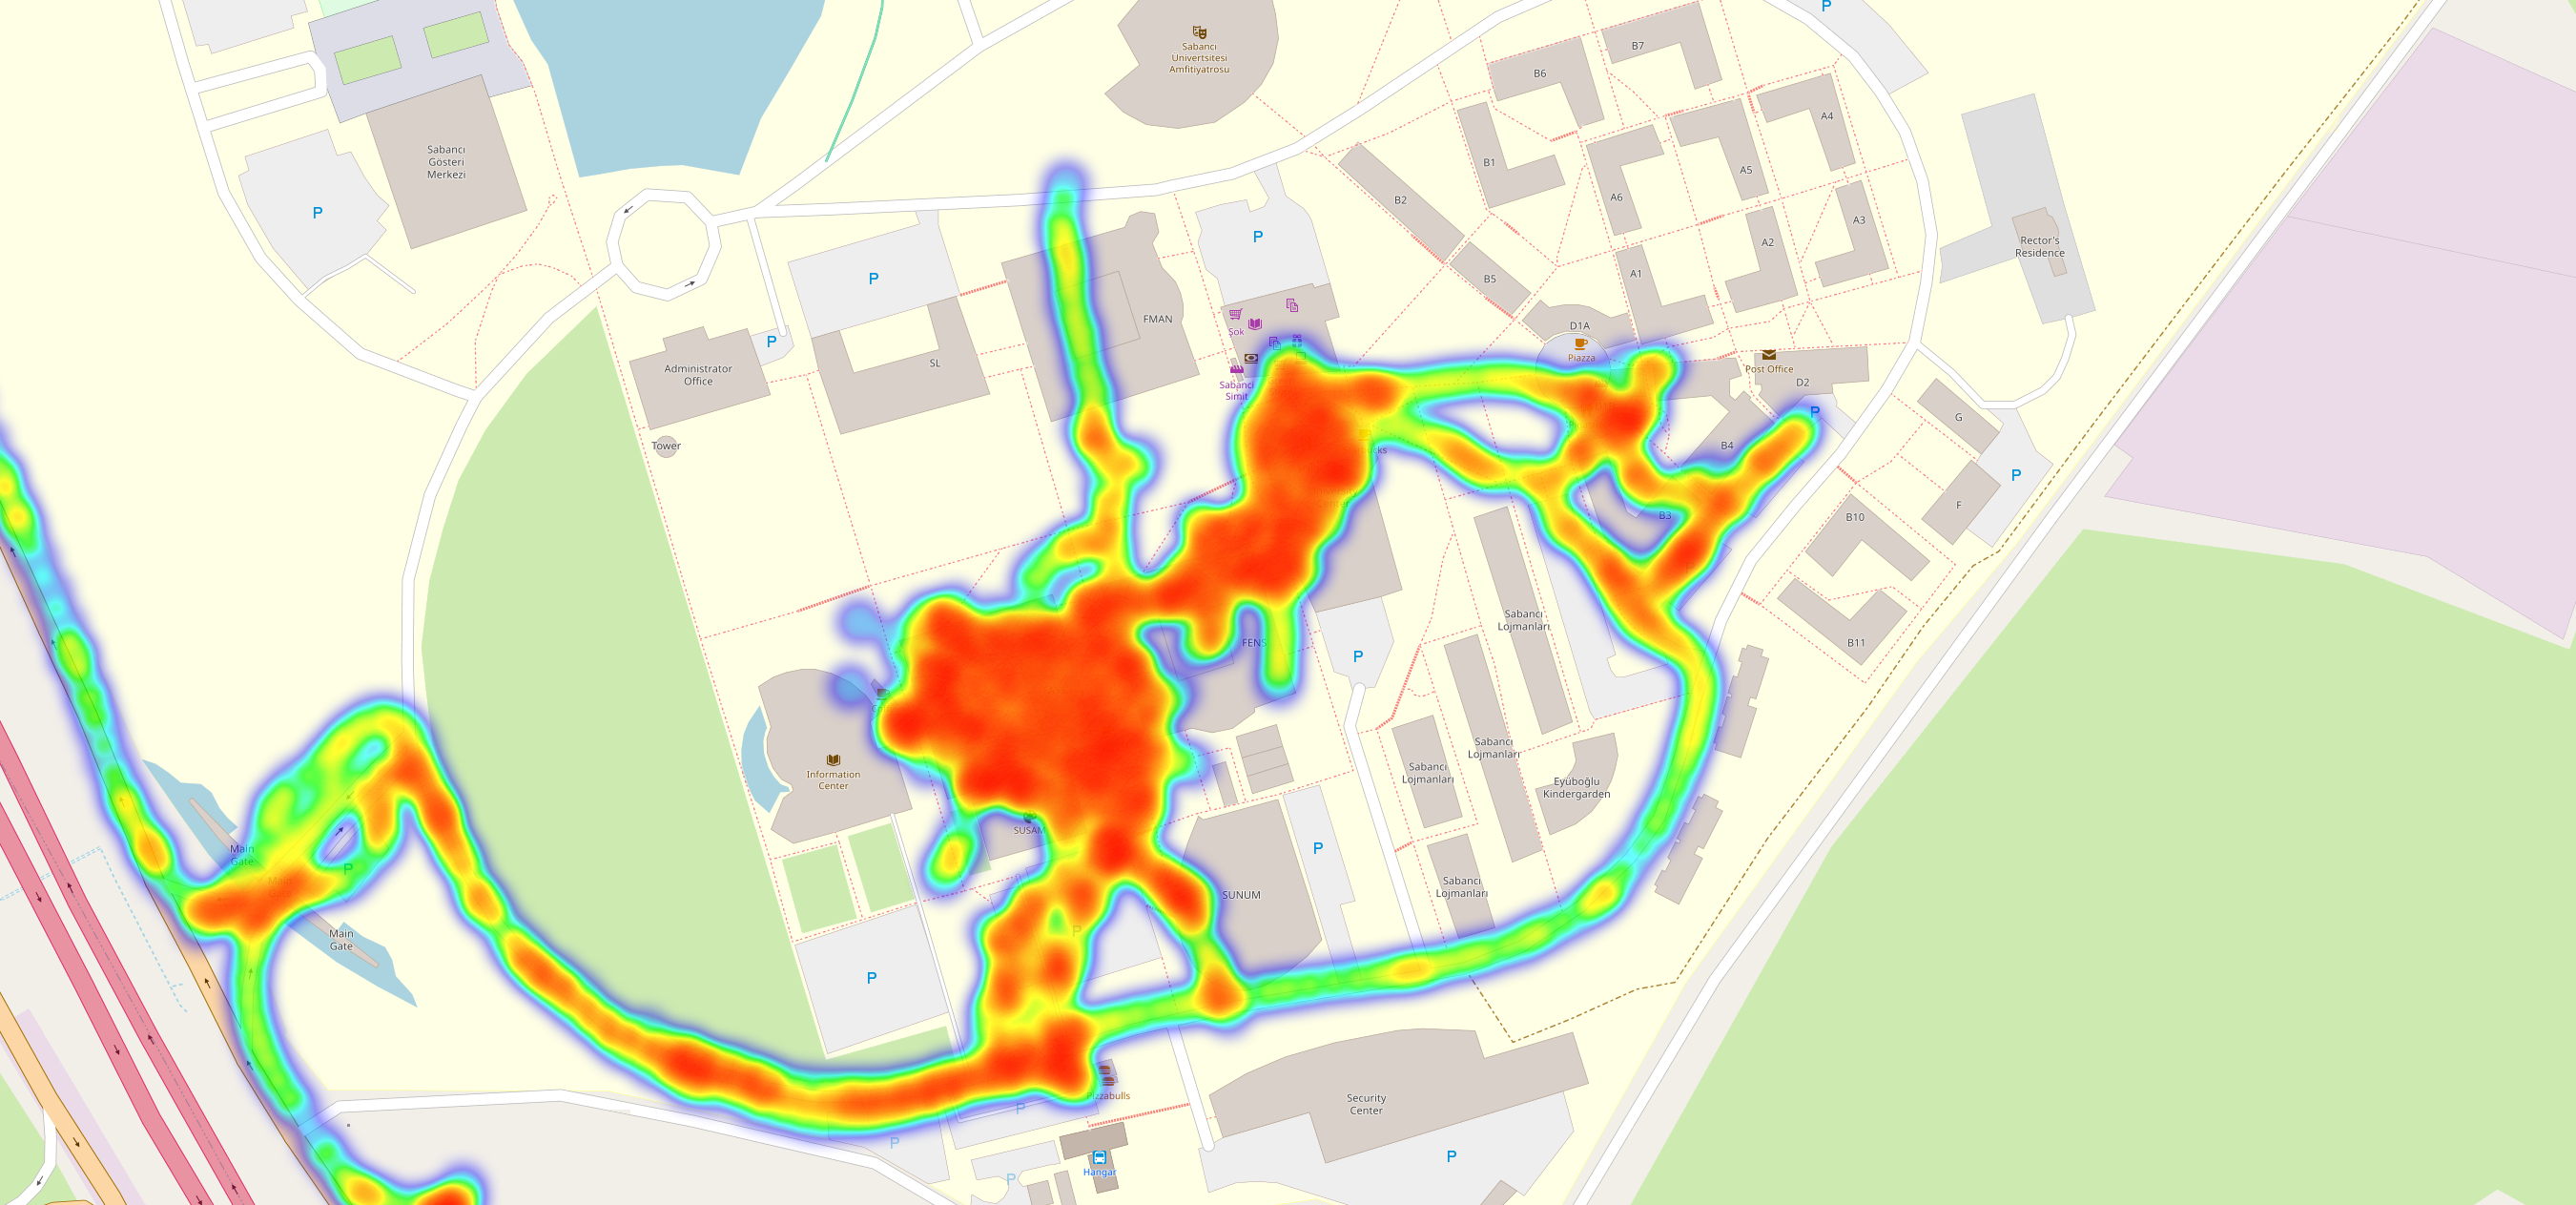